In [ ]:
import scipy.stats as stats
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
warnings.filterwarnings("ignore", category=DeprecationWarning)
from google.colab import files
from sklearn.metrics import (roc_auc_score, log_loss, f1_score, precision_recall_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [ ]:
upload = files.upload()

Saving regime_data.csv to regime_data.csv


In [ ]:
df=pd.read_csv("regime_data.csv")
df['Date']= pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.drop('RV', axis=1)
df = df.rename(columns={'IV': 'VIX'})
df = df.rename(columns={'SKEW': 'IVS'})
df.head()

,VIX,VRP,IVS
Date,,,
1990-01-02,0.1724,0.013732,126.09
1990-01-03,0.1819,0.017098,123.34
1990-01-04,0.1922,0.020951,122.62
1990-01-05,0.2011,0.024846,121.27
1990-01-08,0.2026,0.026346,124.12


In [ ]:
## Continous Regression--daily+threshold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

results = []
daily_data=df.copy()

for col in ['VIX', 'VRP','IVS']:
  for lag in range(23, 45):
      daily_data[f'{col}_lag_{lag}'] = daily_data[col].shift(lag)

daily_data.reset_index(inplace=True)

train_idx, test_idx = train_test_split(daily_data.index, test_size=0.2, shuffle=False)

daily_back=daily_data.copy()

for max_lag in range(23, 30):  # Lag 23 to 44
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(23, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')
    daily_data=daily_back.copy()
    # Define X and y
    X = daily_data[cols]
    y = daily_data['VIX']

    # Clean and align
    X = sm.add_constant(X)
    X, y = X.align(y, join='inner', axis=0)

    # Train/Test split using the pre-defined index
    print (X.index)
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Combine and drop any NaNs/Infs
    train_df = pd.concat([X_train, y_train], axis=1)
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    train_df.dropna(inplace=True)

    # Split them back
    X_train = train_df.drop(columns=y_train.name)
    y_train = train_df[y_train.name]

    # Fit OLS model
    model = sm.OLS(y_train, X_train).fit()
    daily_data.dropna(inplace=True)

    rolling_mean = daily_data['VIX'].rolling(window=2520).mean()
    rolling_std = daily_data['VIX'].rolling(window=2520).std()
    daily_data['VIX_threshold'] = rolling_mean + rolling_std
    daily_data.dropna(inplace=True)

    daily_data['y_pred_train'] = model.predict(X_train)
    daily_data['y_pred_test'] = model.predict(X_test)


    daily_data['target'] = (daily_data['VIX'] > daily_data['VIX_threshold']).astype(int)
    daily_data['trained_target']=(daily_data['y_pred_train'] > daily_data['VIX_threshold']).astype(int)
    daily_data['test_target']=(daily_data['y_pred_test'] > daily_data['VIX_threshold']).astype(int)

    overlap_trained = daily_data.index.intersection(train_idx)
    overlap_test = daily_data.index.intersection(test_idx)



    # Store summary stats
    results.append({
    'max_lag': max_lag,
    'f1_score_train': f1_score( daily_data['target'].loc[overlap_trained] , daily_data['trained_target'].loc[overlap_trained]),
    'f1_score_test': f1_score( daily_data['target'].loc[overlap_test] , daily_data['test_target'].loc[overlap_test]),
    'accuracy_train': accuracy_score( daily_data['target'].loc[overlap_trained] , daily_data['trained_target'].loc[overlap_trained]),
    'accuracy_test': accuracy_score( daily_data['target'].loc[overlap_test] , daily_data['test_target'].loc[overlap_test])
      })


# Convert to DataFrame to view results
results_df = pd.DataFrame(results)
print(results_df)



RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
RangeIndex(start=0, stop=8875, step=1)
   max_lag  f1_score_train  f1_score_test  accuracy_train  accuracy_test
0       23        0.623064       0.521173        0.903460       0.834366
1       24        0.629503       0.514851        0.904783       0.834366
2       25        0.628866       0.506579        0.904783       0.830986
3       26        0.629310       0.494196        0.905224       0.828169
4       27        0.631579       0.504119        0.905885       0.830423
5       28        0.631126       0.493333        0.905444       0.828732
6       29        0.636285       0.492512        0.906767       0.828169


In [ ]:
## Continous Regression--daily+threshold--final model selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

results = []
daily_data=df.copy()

for col in ['VIX', 'VRP','IVS']:
  for lag in range(23, 24):
      daily_data[f'{col}_lag_{lag}'] = daily_data[col].shift(lag)

daily_data.reset_index(inplace=True)


daily_back=daily_data.copy()

for max_lag in range(23, 24):  # Lag 23 to 44
    # Create list of features for all lags up to max_lag
    cols = []
    for lag in range(23, max_lag + 1):
        for var in ['VIX', 'IVS', 'VRP']:
            cols.append(f'{var}_lag_{lag}')


    daily_data=daily_back.copy()

    daily_data.dropna(inplace=True)
    # Define X and y
    X = daily_data[cols]
    y = daily_data['VIX']

    # Clean and align
    X = sm.add_constant(X)
    X, y = X.align(y, join='inner', axis=0)


    # Fit OLS model
    model = sm.OLS(y,X).fit()


    daily_data=daily_back.copy()
    rolling_mean = daily_data['VIX'].rolling(window=2520).mean()
    rolling_std = daily_data['VIX'].rolling(window=2520).std()
    #daily_data['VIX_threshold'] = rolling_mean + rolling_std
    daily_data['VIX_threshold'] = daily_data['VIX'].rolling(window=2520).quantile(0.8)


    X = daily_data[cols]
    X = sm.add_constant(X)

    daily_data['y_pred'] = model.predict(X)
    #daily_data['VIX_threshold'] = daily_data['VIX_threshold'].fillna(threshold_10)
    daily_data['target'] = (daily_data['VIX'] > daily_data['VIX_threshold']).astype(int)
    daily_data['predicted_target']=(daily_data['y_pred'] > daily_data['VIX_threshold']).astype(int)

    daily_data.dropna(inplace=True)

accuracy_score( daily_data['target'] , daily_data['predicted_target'])

0.8750786658275646

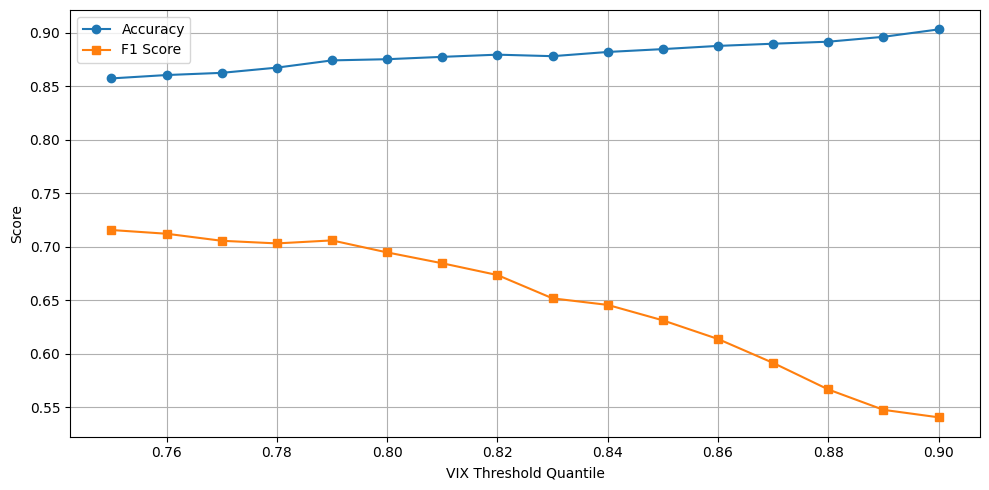

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

quantiles = np.arange(0.75, 0.9, 0.01)
accuracy_list = []
f1_list = []

for q in quantiles:
    daily_data = daily_back.copy()

    # Compute rolling threshold using current quantile
    daily_data['VIX_threshold'] = daily_data['VIX'].rolling(window=2520).quantile(q)

    # Prepare X for prediction
    X = daily_data[cols]
    X = sm.add_constant(X)
    daily_data['y_pred'] = model.predict(X)

    # Binary target generation
    daily_data['target'] = (daily_data['VIX'] > daily_data['VIX_threshold']).astype(int)
    daily_data['predicted_target'] = (daily_data['y_pred'] > daily_data['VIX_threshold']).astype(int)

    daily_data.dropna(inplace=True)

    acc = accuracy_score(daily_data['target'], daily_data['predicted_target'])
    f1 = f1_score(daily_data['target'], daily_data['predicted_target'])

    accuracy_list.append(acc)
    f1_list.append(f1)

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(quantiles, accuracy_list, marker='o', label='Accuracy')
plt.plot(quantiles, f1_list, marker='s', label='F1 Score')
plt.xlabel('VIX Threshold Quantile')
plt.ylabel('Score')
#plt.title('Model Performance Across Different VIX Threshold Quantiles')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
daily_data.dropna(inplace=True)
accuracy_score( daily_data['target'] , daily_data['predicted_target'])

0.8843612334801763

In [ ]:
# Convert 'Date' column to datetime
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Set 'Date' as the index
daily_data.set_index('Date', inplace=True)

# Now you can resample
monthly_data = daily_data.resample('ME').mean()


In [ ]:
monthly_data.dropna (inplace=True)
monthly_data = monthly_data.iloc[1:]
monthly_data

,VIX,VRP,IVS,VIX_lag_23,VRP_lag_23,IVS_lag_23,VIX_threshold,y_pred,target,predicted_target
Date,,,,,,,,,,
2000-01-31,0.232020,0.018364,115.285000,0.219595,0.023844,117.330500,0.243712,0.212889,0.250000,0.000000
2000-02-29,0.235955,0.016645,114.041500,0.230950,0.018007,116.052500,0.243560,0.222084,0.350000,0.100000
2000-03-31,0.227183,0.010543,113.237391,0.237626,0.018067,114.102174,0.243850,0.227254,0.173913,0.043478
2000-04-30,0.271642,0.054029,112.923684,0.223147,0.006528,113.225263,0.244514,0.216868,0.894737,0.000000
2000-05-31,0.263732,0.037929,113.057727,0.267482,0.049703,112.880909,0.245708,0.248140,0.636364,0.500000
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,0.199609,0.032092,154.811739,0.174600,0.015589,156.257826,0.255438,0.178450,0.000000,0.000000
2024-11-30,0.160152,0.018226,153.442381,0.197900,0.031122,155.007143,0.255727,0.195391,0.000000,0.000000
2024-12-31,0.158662,-0.007370,168.840476,0.167819,0.021791,152.154762,0.255578,0.172797,0.047619,0.000000


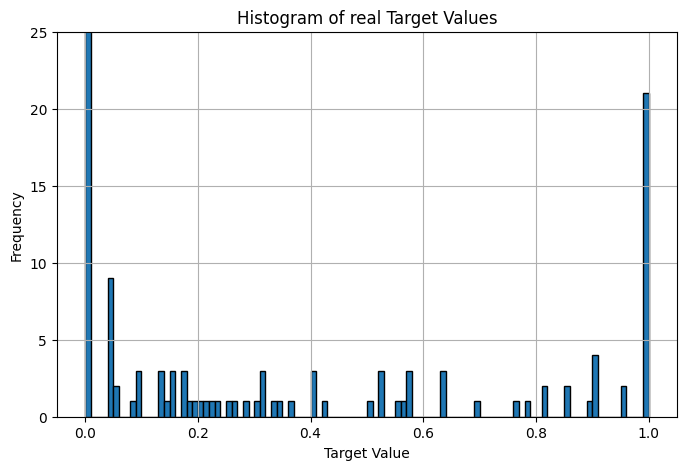

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of the target values
plt.figure(figsize=(8, 5))
plt.hist(monthly_data['target'], bins=100, edgecolor='black')
plt.title('Histogram of real Target Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.ylim(0,25)
plt.grid(True)
plt.show()


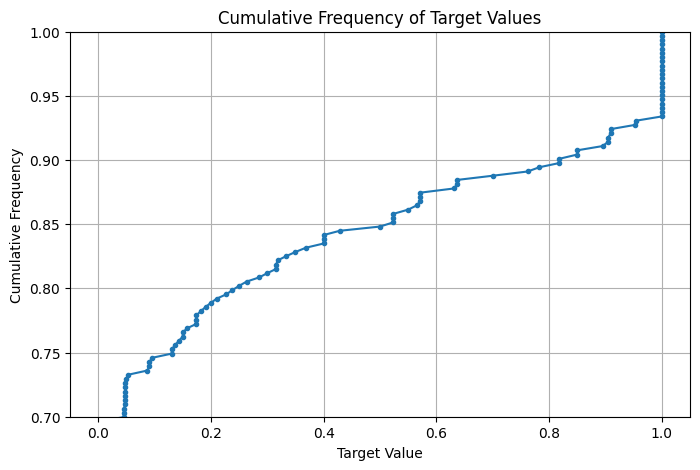

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort target values
sorted_target = np.sort(monthly_data['target'])

# Calculate cumulative frequencies
cumulative_freq = np.arange(1, len(sorted_target) + 1) / len(sorted_target)

# Plot cumulative frequency
plt.figure(figsize=(8, 5))
plt.plot(sorted_target, cumulative_freq, marker='.', linestyle='-')
plt.title('Cumulative Frequency of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Cumulative Frequency')
plt.ylim(0.7,1)
plt.grid(True)
plt.show()


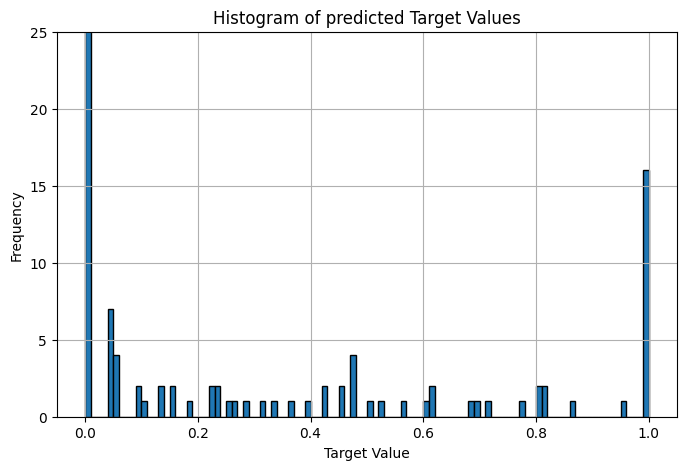

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of the target values
plt.figure(figsize=(8, 5))
plt.hist(monthly_data['predicted_target'], bins=100, edgecolor='black')
plt.title('Histogram of predicted Target Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.ylim(0,25)
plt.grid(True)
plt.show()


In [ ]:
monthly_data

,VIX,VRP,IVS,VIX_lag_23,VRP_lag_23,IVS_lag_23,VIX_threshold,y_pred,target,predicted_target
Date,,,,,,,,,,
1999-12-31,0.232750,0.022416,119.426667,0.210417,0.022921,122.731667,0.243699,0.205826,0.333333,0.000000
2000-01-31,0.232020,0.018364,115.285000,0.219595,0.023844,117.330500,0.243712,0.212889,0.250000,0.000000
2000-02-29,0.235955,0.016645,114.041500,0.230950,0.018007,116.052500,0.243560,0.222084,0.350000,0.100000
2000-03-31,0.227183,0.010543,113.237391,0.237626,0.018067,114.102174,0.243850,0.227254,0.173913,0.043478
2000-04-30,0.271642,0.054029,112.923684,0.223147,0.006528,113.225263,0.244514,0.216868,0.894737,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-10-31,0.199609,0.032092,154.811739,0.174600,0.015589,156.257826,0.255438,0.178450,0.000000,0.000000
2024-11-30,0.160152,0.018226,153.442381,0.197900,0.031122,155.007143,0.255727,0.195391,0.000000,0.000000
2024-12-31,0.158662,-0.007370,168.840476,0.167819,0.021791,152.154762,0.255578,0.172797,0.047619,0.000000


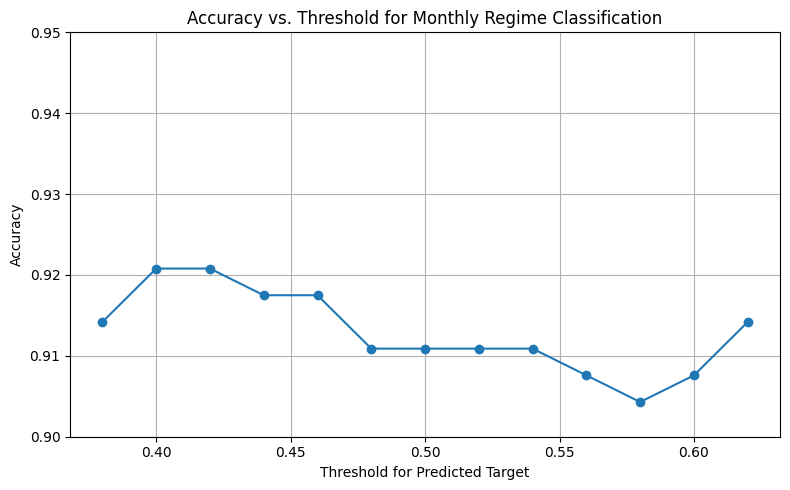

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define threshold range
thresholds = np.arange(0.38, 0.63, 0.02)
accuracies = []

# Loop through thresholds
for t in thresholds:
    predicted_binary = (monthly_data['predicted_target'] > t).astype(int)
    actual_binary = (monthly_data['target'] > t).astype(int)  # fixed target threshold
    acc = accuracy_score(actual_binary, predicted_binary)
    accuracies.append(acc)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel('Threshold for Predicted Target')
plt.ylabel('Accuracy')
plt.ylim(0.9,0.95)
plt.title('Accuracy vs. Threshold for Monthly Regime Classification')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
for_allocation_b=pd.DataFrame()
for_allocation_b[['real signal','predicted signal']]=monthly_data[['target_b','predicted_target_b']]
for_allocation_b.reset_index(inplace=True)
for_allocation_b

,Date,real signal,predicted signal
0,2000-01-31,0,0
1,2000-02-29,1,0
2,2000-03-31,0,0
3,2000-04-30,1,0
4,2000-05-31,1,1
...,...,...,...
297,2024-10-31,0,0
298,2024-11-30,0,0
299,2024-12-31,0,0
300,2025-01-31,0,0


In [ ]:
# 1990-2000 real VIX
df_10=df.loc['1990-01-01':'1999-12-31']
threshold_10=df_10['VIX'].mean()+df_10['VIX'].std()

# Ensure datetime index
df_10.index = pd.to_datetime(df_10.index)

# Step 1: Filter only 1990 data
vix_1990 = df_10.loc['1990']

# Step 2: Calculate the threshold
vix_threshold_1990 = vix_1990['VIX'].mean() + vix_1990['VIX'].std()

# Step 3: Create a new column, default as NaN
df_10['VIX_threshold'] = np.nan


mask_1992_onward = df_10.index >= '1990-01-01'
vix_expanding = df_10.loc[mask_1992_onward, 'VIX'].expanding()

# Compute expanding mean + std and assign
df_10.loc[mask_1992_onward, 'VIX_threshold'] = (
    vix_expanding.mean() + vix_expanding.std()
).values


vix_1990 = df_10.loc['1990']['VIX']
threshold_1990 = vix_1990.mean() + vix_1990.std()
df_10.loc['1990', 'VIX_threshold'] = threshold_1990

# Step 2: 1991 threshold (based on 1990 + 1991)
vix_90_91 = df_10.loc['1990':'1991']['VIX']
threshold_1991 = vix_90_91.mean() + vix_90_91.std()
df_10.loc['1991', 'VIX_threshold'] = threshold_1991

vix_90_92 = df_10.loc['1990':'1992']['VIX']
threshold_1992 = vix_90_92.mean() + vix_90_92.std()
df_10.loc['1992', 'VIX_threshold'] = threshold_1992


df_10['real regime']=np.where(df_10['VIX']>df_10['VIX_threshold'],1,0)

df_10_monthly = df_10.resample('ME').mean()
df_10_monthly['signal']=np.where(df_10_monthly['real regime']>0.5,1,0)


<ipython-input-15-5ffe56c5c77d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10['VIX_threshold'] = np.nan
<ipython-input-15-5ffe56c5c77d>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10['real regime']=np.where(df_10['VIX']>df_10['VIX_threshold'],1,0)


In [ ]:
df_10_monthly
for_allocation_a=pd.DataFrame()
for_allocation_a[['real signal']]=df_10_monthly[['signal']]
for_allocation_a.reset_index(inplace=True)
for_allocation_a

,Date,real signal
0,1990-01-31,0
1,1990-02-28,0
2,1990-03-31,0
3,1990-04-30,0
4,1990-05-31,0
...,...,...
115,1999-08-31,1
116,1999-09-30,1
117,1999-10-31,0
118,1999-11-30,0


In [ ]:
# Make sure both are sorted by date
for_allocation = pd.concat([for_allocation_a, for_allocation_b], axis=0)
for_allocation.sort_values(by='Date', inplace=True)
for_allocation.reset_index(drop=True, inplace=True)
for_allocation['Date'] = pd.to_datetime(for_allocation['Date'])
filtered_df = for_allocation[
    (for_allocation['Date'] >= '1999-12-01') &
    (for_allocation['Date'] <= '2001-12-31')
]
filtered_df

,Date,real signal,predicted signal
119,1999-12-31,0,NaN
120,2000-01-31,0,0.0
121,2000-02-29,1,0.0
122,2000-03-31,0,0.0
123,2000-04-30,1,0.0
124,2000-05-31,1,1.0
125,2000-06-30,0,1.0
126,2000-07-31,0,0.0
127,2000-08-31,0,0.0
128,2000-09-30,0,0.0


In [ ]:
for_allocation

,Date,real signal,predicted signal
0,1990-01-31,0,NaN
1,1990-02-28,0,NaN
2,1990-03-31,0,NaN
3,1990-04-30,0,NaN
4,1990-05-31,0,NaN
...,...,...,...
417,2024-10-31,0,0.0
418,2024-11-30,0,0.0
419,2024-12-31,0,0.0
420,2025-01-31,0,0.0


In [ ]:
for_allocation.to_csv('regime_signal.csv', index=False)


In [ ]:
from google.colab import files
files.download('regime_signal.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>